In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import os
import shutil
import tensorflow as tf
%matplotlib inline
import imghdr

In [2]:
#For avoiding Out of Memory (OOM) errors
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

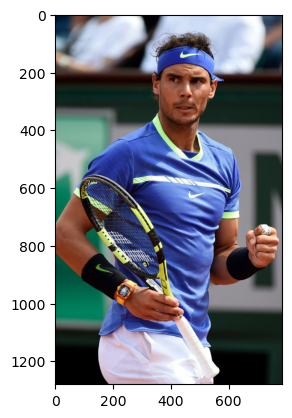

In [3]:
img=cv2.imread('nadal.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

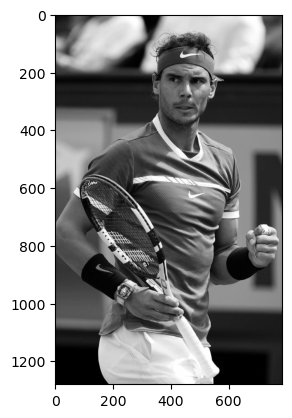

In [4]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')
#matplotlib applies a colormap by default it is a colorful one so we have to use a cmap

In [5]:
faceCascade=cv2.CascadeClassifier('HaarCascades/haarcascade_frontalface_default.xml')
eyeCascade=cv2.CascadeClassifier('HaarCascades/haarcascade_eye.xml')

faces=faceCascade.detectMultiScale(gray,1.3,5)

In [6]:
faces

array([[340, 145, 221, 221]])

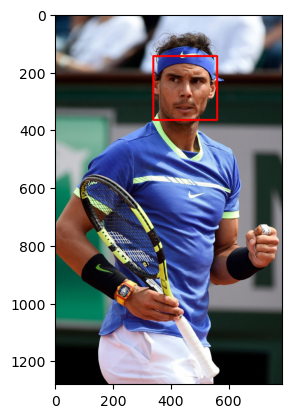

In [7]:
for (x,y,w,h) in faces:
    i=cv2.rectangle(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),(x,y),(x+w,y+h),(255,0,0),5)
plt.imshow(i)

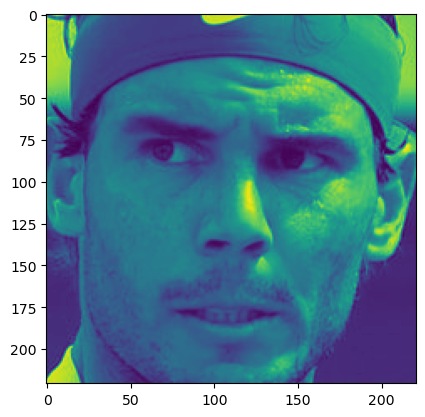

In [8]:
x,y,w,h=faces[0]
plt.imshow(gray[y:y+h,x:x+w])

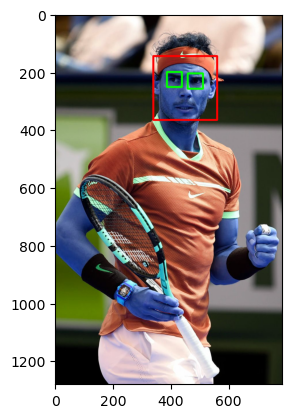

In [9]:
eyes_cascade=cv2.CascadeClassifier('HaarCascades/haarcascade_eye.xml')
for (x,y,w,h) in faces:
    face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
    roi_gray=gray[y:y+h,x:x+w]
    roi_color=face_img[y:y+h,x:x+w]
    eyes=eyes_cascade.detectMultiScale(roi_gray)
    for ex,ey,ew,eh in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),5)
plt.imshow(img)

### Writing a funcn if we input a image and funcn returns the cropped image if face and eyes are detected  

In [10]:
def get_cropped_img_if_2_eyes(image_path):
    img=cv2.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    face_cascade=cv2.CascadeClassifier('HaarCascades/haarcascade_frontalface_default.xml')
    eye_cascade=cv2.CascadeClassifier('HaarCascades/haarcascade_eye.xml')
    faces=face_cascade.detectMultiScale(gray,1.3,5)
    for x,y,w,h in faces:
        face_img=cv2.rectangle(img,(x,y),(x+w,y+h),5)
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=face_img[y:y+h,x:x+w]
        eyes=eye_cascade.detectMultiScale(roi_gray)
        if(len(eyes)>=2):
            return roi_color

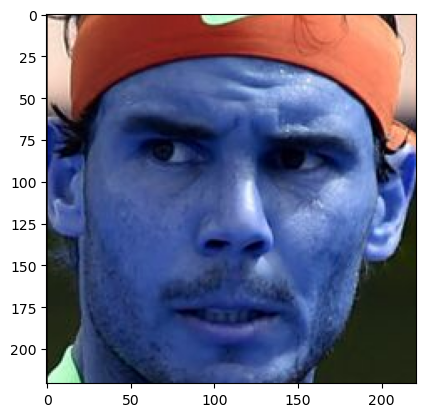

In [11]:
plt.imshow(get_cropped_img_if_2_eyes('nadal.jpg'))

In [12]:
path_data='data/'
path_2_cropped='data/cropped/'

In [13]:
dir_path=[]
for entry in os.scandir(path_data):
    if entry.is_dir():
        dir_path.append(entry.path)

In [14]:
dir_path

['data/LewisHamilton',
 'data/MaxVerstappen',
 'data/messi',
 'data/NeerajChopra',
 'data/RafaelNadal',
 'data/viratkohli']

In [15]:
if os.path.exists(path_2_cropped):
    shutil.rmtree(path_2_cropped)
os.makedirs(path_2_cropped)

In [16]:
'''This code will create a cropped folder consisting of the cropped faces of the celebrities and will also
   remove images which are note openable in opencv or is not supported by tensorflow
'''
cropped_image_dirs=[]      #Helping Variable
celebrity_file_name_dirs={}#Helping Variable will consist of celebrity name as key and the image path as value
img_exts=['jpg','jpeg','png','bmp']   
 
for img_dir in dir_path:
    count=1
    celebrity_name=img_dir.split('/')[-1]

    celebrity_file_name_dirs[celebrity_name]=[]  

    for entry in os.scandir(img_dir):
        tip=imghdr.what(entry.path)
        
        if cv2.imread(entry.path) is None or imghdr.what(entry.path) not in img_exts:
                print('Image not in ext list or is not readable by opencv {}'.format(entry.path))
                os.remove(entry.path) 
            
        else: 
            roi_color=get_cropped_img_if_2_eyes(entry.path)  #returns the cropped face image
            if roi_color is not None:

                #initializes a cropped folder with celebrity name
                cropped_folder=path_2_cropped + celebrity_name

                #Makes a directory if it doesnt exist
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)                 
                    #appends croppped directory path to list which will be used to make image file name
                    cropped_image_dirs.append(cropped_folder)   

                #Making cropped image file name
                cropped_filename=celebrity_name + str(count) +"."+tip 

                #Making cropped image file path for writing the image using opencv
                cropped_filepath=cropped_folder + "/" + cropped_filename

                cv2.imwrite(cropped_filepath,roi_color)

                #appending the image path as value in the particular key
                celebrity_file_name_dirs[celebrity_name].append(cropped_filepath)
                count+=1

# After this manually delete the photos that does not match the celebrity in the directory

In [17]:
data=tf.keras.utils.image_dataset_from_directory('data/cropped',image_size=(256,256))
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()

Found 389 files belonging to 6 classes.


In [18]:
len(batch)

2

In [19]:
class_names = data.class_names
print(class_names)

['LewisHamilton', 'MaxVerstappen', 'NeerajChopra', 'RafaelNadal', 'messi', 'viratkohli']


In [20]:
batch_images, batch_labels = batch
print(batch_labels)

[2 0 4 3 3 1 1 4 2 5 1 2 4 0 0 2 4 5 3 5 3 3 0 2 2 4 1 2 5 4 5 2]


In [21]:
for label in batch_labels:
    print(class_names[label])

NeerajChopra
LewisHamilton
messi
RafaelNadal
RafaelNadal
MaxVerstappen
MaxVerstappen
messi
NeerajChopra
viratkohli
MaxVerstappen
NeerajChopra
messi
LewisHamilton
LewisHamilton
NeerajChopra
messi
viratkohli
RafaelNadal
viratkohli
RafaelNadal
RafaelNadal
LewisHamilton
NeerajChopra
NeerajChopra
messi
MaxVerstappen
NeerajChopra
viratkohli
messi
viratkohli
NeerajChopra


#### So lables are:-
#### 0-LewisHamilton , 1-MaxVerstappen , 2-NeerajChopra , 3-RafaelNadal , 4-messi , 5-viratkohli

In [22]:
class_dict={}
count=0
for celeb_names in class_names:
    class_dict[celeb_names]=count
    count+=1
print(class_dict)

{'LewisHamilton': 0, 'MaxVerstappen': 1, 'NeerajChopra': 2, 'RafaelNadal': 3, 'messi': 4, 'viratkohli': 5}


In [23]:
class_no_to_name={v:k for k,v in class_dict.items()}

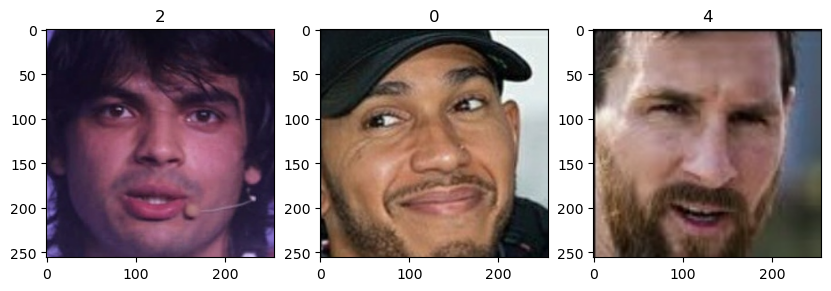

In [24]:
fig,ax=plt.subplots(ncols=3,figsize=(10,10))
for idx,img in enumerate(batch[0][:3]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [25]:
data=data.map(lambda x,y:(x/255,y))

In [26]:
data.as_numpy_iterator().next()[0].max()

1.0

In [27]:
len(data)

13

In [28]:
train_size=int(len(data)*0.8)
test_size=int(len(data)*0.1)
validation_size=(len(data)-train_size-test_size)
print(train_size+test_size+validation_size)

13


In [29]:
train=data.take(train_size)
test=data.skip(train_size).take(test_size)
validation=data.skip(train_size+test_size).take(validation_size)

In [30]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Conv2D,MaxPooling2D,GlobalMaxPooling2D,Dense,Input

In [32]:
K=len(np.unique(batch[1]))
K

6

In [33]:
i=Input(shape=(256,256,3))
        
x=Conv2D(32,(3,3),activation='relu',padding='same')(i)
x=MaxPooling2D((2,2))(x)

x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=MaxPooling2D((2,2))(x)

x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=MaxPooling2D((2,2))(x)

x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=MaxPooling2D((2,2))(x)

x=Flatten()(x)

x=Dense(512,activation='relu')(x)
x=Dense(K,activation='softmax')(x)

model=Model(i,x)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [35]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
history=model.fit(train,validation_data=validation,epochs=20)

Epoch 1/20
10/10 [==============================] - 8s 217ms/step - loss: 2.0815 - accuracy: 0.2062 - val_loss: 1.7005 - val_accuracy: 0.4054
Epoch 2/20
10/10 [==============================] - 2s 156ms/step - loss: 1.7236 - accuracy: 0.2937 - val_loss: 1.5388 - val_accuracy: 0.4324
Epoch 3/20
10/10 [==============================] - 2s 154ms/step - loss: 1.3852 - accuracy: 0.4844 - val_loss: 0.9482 - val_accuracy: 0.6757
Epoch 4/20
10/10 [==============================] - 2s 155ms/step - loss: 1.0733 - accuracy: 0.5938 - val_loss: 0.7242 - val_accuracy: 0.7568
Epoch 5/20
10/10 [==============================] - 2s 156ms/step - loss: 0.7509 - accuracy: 0.7312 - val_loss: 0.7275 - val_accuracy: 0.7568
Epoch 6/20
10/10 [==============================] - 2s 155ms/step - loss: 0.6055 - accuracy: 0.7906 - val_loss: 0.5674 - val_accuracy: 0.8919
Epoch 7/20
10/10 [==============================] - 2s 157ms/step - loss: 0.4760 - accuracy: 0.8531 - val_loss: 0.4036 - val_accuracy: 0.9189
Epoch 

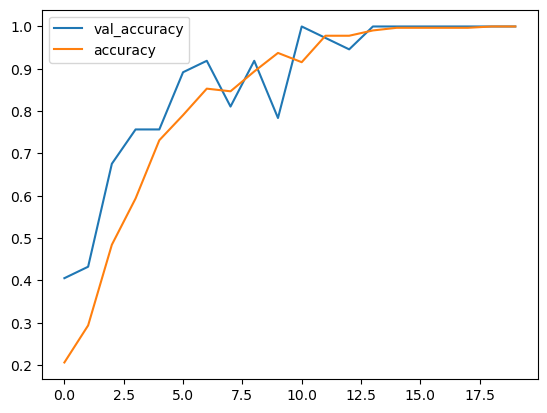

In [38]:
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()

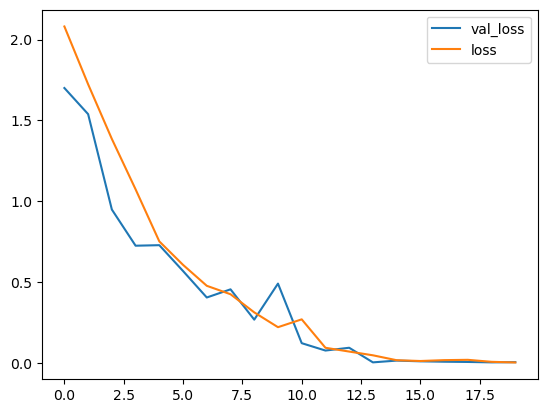

In [39]:
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['loss'],label='loss')
plt.legend()

In [40]:
from tensorflow.keras.metrics import Precision,Recall,Accuracy
pre=Precision()
re=Recall()
acc=Accuracy()

In [41]:
for batch in test.as_numpy_iterator():
    x,y=batch
    predictions=model.predict(x).argmax(axis=1)
    pre.update_state(y,predictions)
    re.update_state(y,predictions)
    acc.update_state(y,predictions)
    cm=tf.math.confusion_matrix(y,predictions)

1/1 [==============================] - 0s 109ms/step


In [42]:
print(f'Precision:{pre.result().numpy()},recall:{re.result().numpy()},acc:{acc.result().numpy()}')

Precision:1.0,recall:1.0,acc:1.0


Text(50.722222222222214, 0.5, 'True values')

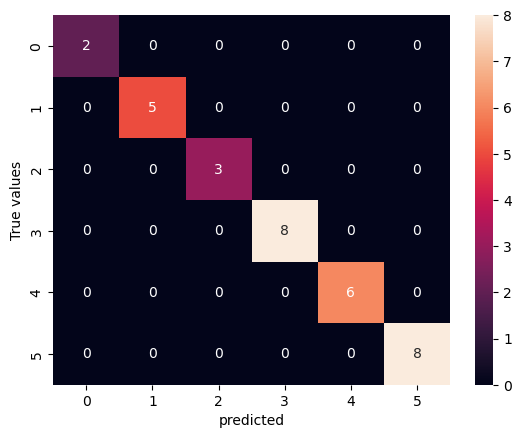

In [43]:
sns.heatmap(cm,annot=True)#,fmt='/d'
plt.xlabel('predicted')
plt.ylabel('True values')

In [44]:
import h5py

In [45]:
model.save(os.path.join('savedmodel','Saved_model.h5'))

### It will only be able to clasify images that are openable in opencv and tensorflow and also that are within these 6 classses.

In [46]:
def classify_image(image_path):
    test_img=get_cropped_img_if_2_eyes(image_path)
    test_img=tf.image.resize(test_img,(256,256))
    y_pred=model.predict(np.expand_dims(test_img/255,0)).argmax(axis=1)
    return class_no_to_name[y_pred[0]]

In [47]:
sports_person=classify_image('Test Images/lewis1.png')
print(sports_person)

1/1 [==============================] - 0s 411ms/step
NeerajChopra
